In [ ]:
%%capture
import os, json, zipfile, shutil, platform, time

import scipy.sparse as sps
from pandas import DataFrame
import pandas as pd
import numpy as np

import multiprocessing
import multiprocessing.pool
import time

import gc 
from random import randint
targetCol="reply"
targets=["like",	"retweet",	"retweetCom",	"reply",	"interaction"]
droppable=[t for t in targets if t!=targetCol]
all_features = ["text_tokens", "hashtags", "tweet_id", "present_media", "present_links", "present_domains",\
                "tweet_type","language", "tweet_timestamp", "engaged_with_user_id", "engaged_with_user_follower_count",\
               "engaged_with_user_following_count", "engaged_with_user_is_verified", "engaged_with_user_account_creation",\
               "engaging_user_id", "engaging_user_follower_count", "engaging_user_following_count", "engaging_user_is_verified",\
               "engaging_user_account_creation", "engagee_follows_engager","reply_timestamp", "retweet_timestamp", "retweet_with_comment_timestamp", "like_timestamp"]

#Join feature with  dataset

In [ ]:
import pandas as pd

In [ ]:
origin="drive/MyDrive/twitter/onechunk/"

In [ ]:
import os   
os.system(f"cp {origin}train.bz2 ../content/")
os.system(f"cp {origin}test.bz2 ../content/")

0

In [ ]:
!bunzip2 train.bz2
!bunzip2 test.bz2
!mv train train.csv
!mv test test.csv

In [ ]:
train=pd.read_csv("train.csv", index_col=0)
test=pd.read_csv("test.csv", index_col=0)


/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
for col in train.columns:
    if col  in droppable:
        train.drop(col,axis=1,inplace=True)
    if col in ["engaged_with_user_id","engaging_user_id","language"]:
        train.drop(col,axis=1,inplace=True)

train["engaged_with_user_is_verified"] = train["engaged_with_user_is_verified"].astype(int)
train["engaging_user_is_verified"] = train["engaging_user_is_verified"].astype(int)
train["engagee_follows_engager"] = train["engagee_follows_engager"].astype(int)
import gc 
gc.collect()

3750

In [ ]:
train.head()

,text_tokens,hashtags,present_media,present_links,present_domains,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaging_user_follower_count,engaging_user_following_count,engaging_user_is_verified,engagee_follows_engager,reply,photos,gifs,videos,tweet_type_Quote,tweet_type_Retweet,tweet_type_TopLevel
0,50,0,0,0,0,2473,662,0,169,339,0,0,0,0,0,0,0,1,0
2,39,0,0,1,1,219715,3685,1,629,1473,0,0,0,0,0,0,0,0,1
3,40,0,0,0,0,2388283,13511,1,123,200,0,0,0,0,0,0,0,1,0
4,66,0,1,0,0,414,720,0,134,379,0,1,0,1,0,0,0,0,1
5,3,0,0,0,0,673,561,0,2322,996,0,1,0,0,0,0,1,0,0


In [ ]:
for col in test.columns:
    if col  in droppable:
        test.drop(col,axis=1,inplace=True)
    if col in ["engaged_with_user_id","engaging_user_id","language"]:
        test.drop(col,axis=1,inplace=True)

test["engaged_with_user_is_verified"] = test["engaged_with_user_is_verified"].astype(int)
test["engaging_user_is_verified"] = test["engaging_user_is_verified"].astype(int)
test["engagee_follows_engager"] = test["engagee_follows_engager"].astype(int)
import gc 
gc.collect()

62

In [ ]:
test.head()

,text_tokens,hashtags,present_media,present_links,present_domains,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaging_user_follower_count,engaging_user_following_count,engaging_user_is_verified,engagee_follows_engager,reply,photos,gifs,videos,tweet_type_Quote,tweet_type_Retweet,tweet_type_TopLevel
1,78,0,0,1,1,4418640,228,1,393,1190,0,0,0,0,0,0,0,0,1
9,77,0,0,1,1,881,583,0,355,650,0,0,0,0,0,0,0,0,1
10,62,0,0,0,0,133933,5371,0,83,265,0,0,0,0,0,0,0,0,1
15,19,0,0,0,0,234,409,0,24,138,0,1,1,0,0,0,1,0,0
27,32,0,1,0,0,357,474,0,407,416,0,1,0,1,0,0,0,0,1


In [ ]:
for col in train.columns:
    if col!= targetCol:
        print(col)
        mean=np.mean(train[col].values)
        std=np.std(train[col].values)
        train[col]=(train[col]-mean)/std
        test[col]=(test[col]-mean)/std

text_tokens
hashtags
present_media
present_links
present_domains
engaged_with_user_follower_count
engaged_with_user_following_count
engaged_with_user_is_verified
engaging_user_follower_count
engaging_user_following_count
engaging_user_is_verified
engagee_follows_engager
photos
gifs
videos
tweet_type_Quote
tweet_type_Retweet
tweet_type_TopLevel


In [ ]:
train.head()

,text_tokens,hashtags,present_media,present_links,present_domains,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaging_user_follower_count,engaging_user_following_count,engaging_user_is_verified,engagee_follows_engager,reply,photos,gifs,videos,tweet_type_Quote,tweet_type_Retweet,tweet_type_TopLevel
0,0.143959,-0.35482,-0.621357,-0.338503,-0.338503,-0.168332,-0.089882,-0.473339,-0.065824,-0.219323,-0.040872,-0.865018,0,-0.528032,-0.11321,-0.274214,-0.297838,1.431504,-1.200998
2,-0.231435,-0.35482,-0.621357,2.578761,2.578761,-0.119589,0.001932,2.112652,-0.017991,0.458418,-0.040872,-0.865018,0,-0.528032,-0.11321,-0.274214,-0.297838,-0.698566,0.832641
3,-0.197309,-0.35482,-0.621357,-0.338503,-0.338503,0.366977,0.300363,2.112652,-0.070607,-0.302398,-0.040872,-0.865018,0,-0.528032,-0.11321,-0.274214,-0.297838,1.431504,-1.200998
4,0.689987,-0.35482,0.499741,-0.338503,-0.338503,-0.168794,-0.088120,-0.473339,-0.069463,-0.195417,-0.040872,1.156045,0,0.591604,-0.11321,-0.274214,-0.297838,-0.698566,0.832641
5,-1.459999,-0.35482,-0.621357,-0.338503,-0.338503,-0.168736,-0.092949,-0.473339,0.158056,0.173336,-0.040872,1.156045,0,-0.528032,-0.11321,-0.274214,3.357529,-0.698566,-1.200998


In [ ]:
target=train[targetCol]
target=target.astype("float32")
target=target.values
targetTest=test[targetCol]
targetTest=targetTest.astype("float32")
targetTest=targetTest.values

In [ ]:
train.drop(targetCol,axis=1,inplace=True)
test.drop(targetCol,axis=1,inplace=True)

In [ ]:
features=len(train.columns)

In [ ]:
input=train.values
inputTest=test.values

In [ ]:
del train
del test


#Model

In [ ]:
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from math import ceil
from tqdm import tqdm
from keras.models import Sequential
from keras.layers.core import Dense,Activation,Dropout
from keras.optimizers import RMSprop
from tensorflow.keras import regularizers

In [ ]:
import tensorflow.keras.backend as K
def create_weighted_binary_crossentropy(zero_weight, one_weight):
    def weighted_binary_crossentropy(y_true, y_pred):
        b_ce = K.binary_crossentropy(y_true, y_pred)
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce
        return K.mean(weighted_b_ce)
    return weighted_binary_crossentropy

In [ ]:
unique, counts = np.unique(target, return_counts=True)
if unique[0]==0:
    bias=counts[1]/counts[0]
else:
    bias=counts[0]/counts[1]
bias=np.log(bias)

In [ ]:
def buildModel(targetCol,bias=None):
    if bias is not None:
        bias = tf.keras.initializers.Constant(bias)
    if targetCol=="like":
        model = Sequential()
        size=64
        reduction_factor=2
        shape=(features,)
        depth=2
        dropout=0.4
        BS=16
        kernel_resularizer_norm=1e-5
        for i in range(depth):
                    model.add(Dense(size,  input_shape=shape,kernel_regularizer=regularizers.l2(kernel_resularizer_norm)))
                    model.add(Activation("relu"))
                    model.add(Dropout(dropout))
                    size=size//reduction_factor
        model.add(Dense(1,kernel_regularizer=regularizers.l2(1e-4),bias_initializer=bias))
        model.add(Activation("sigmoid"))
        loss=create_weighted_binary_crossentropy(1,1)
        model.compile(loss=loss, metrics=[tf.keras.metrics.AUC(curve="PR",name="PRAUC"),"accuracy"],optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002))
    if targetCol=="retweet":
        model = Sequential()
        model.add(tf.keras.layers.BatchNormalization())
        size=32
        reduction_factor=2
        shape=(features,)
        depth=2
        dropout=0.6
        BS=32
        kernel_resularizer_norm=3e-5
        for i in range(depth):
                    model.add(Dense(size,  input_shape=shape,kernel_regularizer=regularizers.l2(kernel_resularizer_norm)))
                    model.add(Activation("relu"))
                    model.add(Dropout(dropout))
                    size=size//reduction_factor
        model.add(tf.keras.layers.BatchNormalization())
        model.add(Dense(1,kernel_regularizer=regularizers.l2(3e-4),bias_initializer=bias))
        model.add(Activation("sigmoid"))
        loss=create_weighted_binary_crossentropy(1,1)
        model.compile(loss=loss, metrics=[tf.keras.metrics.AUC(curve="PR",name="PRAUC"),"accuracy"],optimizer=tf.keras.optimizers.Adam(learning_rate=0.02))
    if targetCol=="reply":
        model = Sequential()
        size=64
        reduction_factor=2
        shape=(features,)
        depth=2
        dropout=0.6
        BS=32
        kernel_resularizer_norm=1e-5
        for i in range(depth):
                    model.add(Dense(size,  input_shape=shape,kernel_regularizer=regularizers.l2(kernel_resularizer_norm)))
                    model.add(Activation("relu"))
                    model.add(Dropout(dropout))
                    size=size//reduction_factor
        model.add(Dense(1,kernel_regularizer=regularizers.l2(1e-4),bias_initializer=bias))
        model.add(Activation("sigmoid"))
        loss=create_weighted_binary_crossentropy(1,2)
        model.compile(loss=loss, metrics=[tf.keras.metrics.AUC(curve="PR",name="PRAUC"),"accuracy"],optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002))
    
    return model,BS

In [ ]:
model,BS=buildModel(targetCol,bias=bias)

In [ ]:
gc.collect()
model.fit(input,target,epochs=5,batch_size=BS)#, validation_split=0.2)

Epoch 1/5
75834/75834 [==============================] - 132s 2ms/step - loss: 0.2165 - PRAUC: 0.0608 - accuracy: 0.9698
Epoch 2/5
75834/75834 [==============================] - 133s 2ms/step - loss: 0.2063 - PRAUC: 0.0719 - accuracy: 0.9704
Epoch 3/5
75834/75834 [==============================] - 137s 2ms/step - loss: 0.2067 - PRAUC: 0.0730 - accuracy: 0.9703
Epoch 4/5
75834/75834 [==============================] - 150s 2ms/step - loss: 0.2063 - PRAUC: 0.0728 - accuracy: 0.9703
Epoch 5/5
30844/75834 [===========>..................] - ETA: 1:20 - loss: 0.2089 - PRAUC: 0.0736 - accuracy: 0.9698

In [ ]:
gc.collect()

In [ ]:
prediction=model.predict(inputTest)

In [ ]:
prediction

array([[0.26284036],
       [0.31509995],
       [0.5292958 ],
       ...,
       [0.4651538 ],
       [0.5049377 ],
       [0.24150816]], dtype=float32)

In [ ]:
from sklearn.metrics import average_precision_score, log_loss

def calculate_ctr(gt):
  positive = len([x for x in gt if x == 1])
  ctr = positive/float(len(gt))
  return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred-1e-7)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/(strawman_cross_entropy+1e-7))*100.0

rce = compute_rce(prediction,targetTest)
average_precision = average_precision_score(targetTest,prediction)

In [ ]:
average_precision

In [ ]:
rce

In [ ]:
model.save(f"baseNet-{targetCol}.h5")

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#Only Bert 

##Get Bert Input 

In [ ]:
import pandas as pd

In [ ]:
trainDataset="drive/MyDrive/twitter/onechunk/part-00000.lzo"

In [ ]:
%%capture
!apt-get install lzop

In [ ]:
!cp "drive/MyDrive/twitter/onechunk/part-00000.lzo" file.lzo

In [ ]:
!lzop -x file.lzo
!mv file Dataset.csv

In [ ]:
train= pd.read_csv("Dataset.csv",sep='\x01',header=None)


In [ ]:
train.columns=all_features

In [ ]:
train["like"]=train["like_timestamp"].apply(lambda row: 1 if row>0 else 0).astype("uint8")
train.drop("like_timestamp",axis=1,inplace=True)

train["retweet"]=train["retweet_timestamp"].apply(lambda row: 1 if row>0 else 0).astype("uint8")
train.drop("retweet_timestamp",axis=1,inplace=True)

train["retweetCom"]=train["retweet_with_comment_timestamp"].apply(lambda row: 1 if row>0 else 0).astype("uint8")
train.drop("retweet_with_comment_timestamp",axis=1,inplace=True)

train["reply"]=train["reply_timestamp"].apply(lambda row: 1 if row>0 else 0).astype("uint8")
train.drop("reply_timestamp",axis=1,inplace=True)


In [ ]:
import gc
gc.collect()
train["interaction"]=train["reply"]+train["like"]+train["retweet"]+train["retweetCom"]
train["interaction"]=train["interaction"].astype("uint8")

In [ ]:
for col in train.columns:
    if col not in [targetCol,"text_tokens"]:
        train.drop(col,axis=1,inplace=True)

In [ ]:


def cleanAndAdapt(row):
    row=row.split("\t")
    if len(row)>511:
        row=row[:511]
    #else:
    #    row=row+([0]*(511-len(row)))
    return [int(i) for i in row]

def attentionMask(row):
    return [ 1 if i!=0 else 0 for i in row]

train["text_tokens"]=train["text_tokens"].apply(cleanAndAdapt)
train["attentionMask"]=train["text_tokens"].apply(attentionMask)

gc.collect()

0

In [ ]:
train.head()

,text_tokens,retweet,attentionMask
0,"[101, 56898, 137, 16925, 10731, 11481, 13980, ...",0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"[101, 10159, 11322, 58550, 10836, 10126, 25900...",0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"[101, 10159, 56314, 14364, 10109, 14657, 11359...",0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,"[101, 56898, 137, 10224, 10731, 64194, 41939, ...",0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"[101, 7143, 1938, 113, 100, 10097, 100, 10097,...",0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [ ]:
msk = np.random.rand(len(train)) < 0.8
test=train[~msk]
train=train[msk]

In [ ]:
target=train[targetCol]
target=target.astype("float32")
target=target.values
targetTest=test[targetCol]
targetTest=targetTest.astype("float32")
targetTest=targetTest.values

In [ ]:
train.drop(targetCol,axis=1,inplace=True)
test.drop(targetCol,axis=1,inplace=True)

In [ ]:
input=train.values
inputTest=test.values

In [ ]:
del train
del test

##Bert Model

In [ ]:
%%capture
!pip install bert-for-tf2
!pip install sentencepiece
!pip install -q tensorflow-text
!pip install transformers

In [ ]:
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from math import ceil
from tqdm import tqdm
from keras.models import Sequential
from keras.layers.core import Dense,Activation,Dropout
from keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from tensorflow import keras

from tensorflow.keras import layers
from transformers import BertTokenizer, TFBertModel, BertConfig,TFBertForSequenceClassification,TFDistilBertModel,DistilBertConfig

In [ ]:
EMB_SIZE=32
NUM_TOKENS=511

In [ ]:
config = DistilBertConfig.from_pretrained("distilbert-base-multilingual-cased", output_hidden_states=False)

In [ ]:
encoder = TFDistilBertModel.from_pretrained('distilbert-base-multilingual-cased',config=config)

Some layers from the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
encoder.trainable=False

In [ ]:
input_ids = layers.Input(shape=(NUM_TOKENS,), dtype=tf.int32,name="tokens")
attention_mask = layers.Input(shape=(NUM_TOKENS,), dtype=tf.int32,name="mask")
#embedding = encoder(       {"input_ids":input_ids,"attention_mask":attention_mask})[1]
embedding = encoder(       {"input_ids":input_ids,"attention_mask":attention_mask})[0]
#encoder({"input_ids":input_ids,"attention_mask":attention_mask})

#embeddingFixed=layers.Flatten()(embedding)
embeddingFixed=layers.GlobalAveragePooling1D()(embedding)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [ ]:
hidden_1 = layers.Dense(128, name="h_1",activation="relu")(embeddingFixed)
drop_1=layers.Dropout(0.5)(hidden_1)
emb=layers.Dense(EMB_SIZE, name="emb_text",activation="relu")(drop_1)
drop_2=layers.Dropout(0.5)(emb)

out=layers.Dense(1,kernel_regularizer=regularizers.l2(1e-4),activation="sigmoid")(drop_2)

In [ ]:
model=keras.Model(inputs=[input_ids,attention_mask], outputs=out, name="NN")

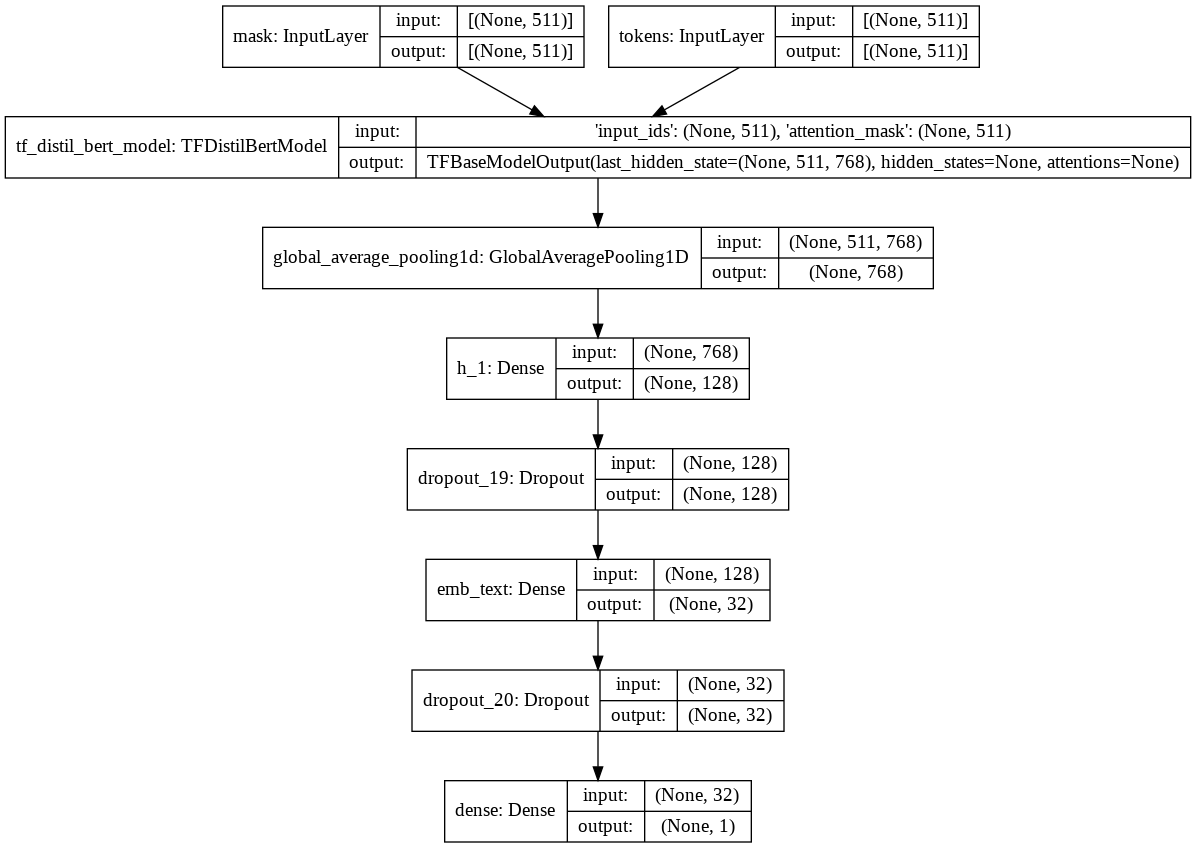

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
loss=tf.keras.losses.BinaryCrossentropy()#   from_logits=True)
lr=0.0003
optimizer=tf.keras.optimizers.Adam(learning_rate=lr)
train_acc_metric=tf.keras.metrics.AUC(curve="PR",name="PRAUC")
model.compile(loss=loss,optimizer=optimizer,metrics=[train_acc_metric,"accuracy"])

##Custom Dataset

In [ ]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,inputs, outputs,num_tokens, batch_size=32):
        'Initialization'
        self.batch_size = batch_size
        self.inputs = inputs
        self.outputs = outputs
        self.length= len(inputs)
        self.num_tokens=num_tokens
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.length / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = range(index*self.batch_size,(index+1)*self.batch_size)

        # Find list of IDs

        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        pass

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        text_batch = np.empty((self.batch_size,self.num_tokens))
        mask = np.empty((self.batch_size,self.num_tokens))
        
        y = np.empty((self.batch_size), dtype=np.float32)

        # Generate data
        for i in indexes:
            row=self.inputs[i]
            
            text=row[0]
            att=row[1]
            
            length=511-len(text)

            text=text+([0]*length)
            att=att+([0]*length)

            text_batch[i%self.batch_size,] = np.array(text)
            mask[i%self.batch_size,]=np.array(att)
            

            # Store class
            y[i%self.batch_size] = self.outputs[i]
        
        
        return (text_batch,mask), y

##Fit

In [ ]:
gc.collect()

0

In [ ]:
BATCH_SIZE=128

In [ ]:
training_generator = DataGenerator(input, target,num_tokens=NUM_TOKENS,batch_size=BATCH_SIZE)
test_generator = DataGenerator(inputTest, targetTest,num_tokens=NUM_TOKENS,batch_size=BATCH_SIZE)

In [ ]:
training_generator.__getitem__(1)[0][0][0][0]

101.0

In [ ]:
model.fit(training_generator,epochs=1)

In [ ]:
model.evaluate(test_generator)

In [ ]:
model.fit(training_generator,epochs=1)

In [ ]:
model.evaluate(test_generator)